# Assignment 3
## Deep Learning Technologies
### Shruti Badrinarayanan - 016768141

[Github Link](https://github.com/shruti-badri-14/Deep-Learning-Homework/tree/main/Assignment%203)

# Step 1

Create your own custom dataset featuring 3 custom categories of at least 100 images each

I am using 3 categories from the "CIFAR-10" dataset, which is a popular dataset for image classification tasks. The categories are: 'airplane', 'automobile', 'bird'.

In [153]:
import torch
import torchvision
import numpy as np

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

# Select only the samples belonging to the categories: airplane (class 0), automobile (class 1), and bird (class 2)
selected_classes = [0, 1, 2]

# Filter training set
train_indices = [i for i, label in enumerate(train_dataset.targets) if label in selected_classes]
train_images = train_dataset.data[train_indices]
train_labels = np.array(train_dataset.targets)[train_indices]

# Filter test set
test_indices = [i for i, label in enumerate(test_dataset.targets) if label in selected_classes]
test_images = test_dataset.data[test_indices]
test_labels = np.array(test_dataset.targets)[test_indices]

# Display some information about the filtered dataset
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)
print("Number of classes:", len(selected_classes))

Files already downloaded and verified
Files already downloaded and verified
Training images shape: (15000, 32, 32, 3)
Training labels shape: (15000,)
Test images shape: (3000, 32, 32, 3)
Test labels shape: (3000,)
Number of classes: 3


# Step 2
Split this data between 80% training and 20% test



In [154]:
from torch.utils.data import Subset, DataLoader, random_split

# Convert numpy arrays to PyTorch tensors
train_images_tensor = torch.tensor(train_images)
train_labels_tensor = torch.tensor(train_labels)

# Combine images and labels into a dataset
train_dataset = torch.utils.data.TensorDataset(train_images_tensor, train_labels_tensor)

# Define the sizes of the training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the training dataset into training and validation sets
train_set, val_set = random_split(train_dataset, [train_size, val_size])

# Create DataLoader for training, validation, and test sets
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)


test_images_tensor = torch.tensor(test_images)
test_labels_tensor = torch.tensor(test_labels)
test_dataset = torch.utils.data.TensorDataset(test_images_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Check the sizes of training and validation sets
print("Training set size:", len(train_set))
print("Validation set size:", len(val_set))
print("Test set size:", len(test_dataset))

Training set size: 12000
Validation set size: 3000
Test set size: 3000


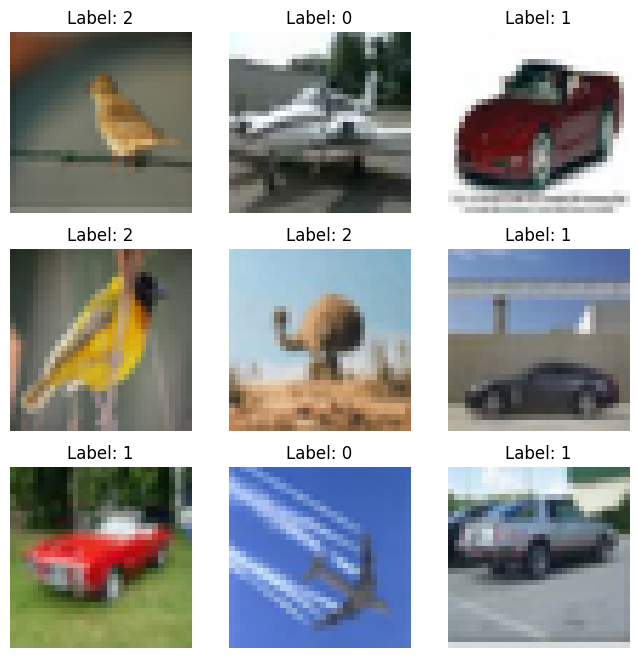

In [155]:
import matplotlib.pyplot as plt

# Function to display images in a grid
def show_samples(images, labels, num_samples=9):
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')
    plt.show()

# Get some samples from the training set
sample_images = [train_set[i][0] for i in range(9)]
sample_labels = [train_set[i][1] for i in range(9)]

# Display the samples in a grid
show_samples(sample_images, sample_labels)

# Step 3
Preprocess the data as you see fit

Normalise the data

In [156]:
import torchvision.transforms as transforms

# Define transformations for data preprocessing
train_transform = transforms.Compose([
    transforms.ToPILImage(),                # Convert numpy array to PIL Image
    transforms.RandomHorizontalFlip(),     # Randomly flip the image horizontally
    transforms.RandomRotation(10),         # Randomly rotate the image by up to 10 degrees
    transforms.ToTensor(),                 # Convert PIL Image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image with mean and standard deviation
])

# No data augmentation for validation and test sets, only normalization is done
val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Apply transformations to the datasets
train_set.dataset.transform = train_transform
val_set.dataset.transform = val_transform
test_images_tensor = torch.tensor(test_images) # Convert to tensor and permute dimensions
test_labels_tensor = torch.tensor(test_labels)
test_set = torch.utils.data.TensorDataset(test_images_tensor, test_labels_tensor)
test_set.transform = val_transform

# Check the transformed datasets
print("Transformed training dataset:", train_set.dataset)
print("Transformed validation dataset:", val_set.dataset)
print("Transformed test dataset:", test_set)

# Now I will use these transformed datasets for training, validation, and testing.

Transformed training dataset: <torch.utils.data.dataset.TensorDataset object at 0x7815624fe650>
Transformed validation dataset: <torch.utils.data.dataset.TensorDataset object at 0x7815624fe650>
Transformed test dataset: <torch.utils.data.dataset.TensorDataset object at 0x78148a3ef850>


# Step 4
Create a Convolutional Neural Network model to learn about your training set

In [157]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

image_height = 32
image_width = 32

# Define transformations for resizing and data preprocessing
resize_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((image_height, image_width)),  # Resize images to 32x32 pixels
    transforms.ToTensor(),  # Convert images to tensors
])

# Apply resize transformation to the datasets
train_set.dataset.transform = resize_transform
val_set.dataset.transform = resize_transform
test_set.transform = resize_transform

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        # Define max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Define fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 3)  # 3 classes: airplane, automobile, bird

    def forward(self, x):
        # Apply convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # Flatten the image representation
        x = x.reshape(-1, 64 * 4 * 4)
        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the CNN model
model = CNNModel()
print(model)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)


In [161]:
# Function to perform one epoch of training
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    running_accuracy = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.float()  # Convert input data to float
        # inputs = inputs[:, None, :, :]
        inputs = inputs.permute(0, 3, 1, 2)
        labels = labels.long()   # Convert labels to long (int) format
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize the weights
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

# Function to perform one epoch of validation
def validate_epoch(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    running_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.float()  # Convert input data to float
            inputs = inputs.permute(0, 3, 1, 2)
            # inputs = inputs[:, None, :, :]
            labels = labels.long()   # Convert labels to long (int) format
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(val_loader.dataset)
    return epoch_loss

In [162]:
# Define the number of epochs
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    # Training
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    # Validation
    val_loss = validate_epoch(model, val_loader, criterion)
    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}')

print('Training finished.')

Epoch [1/10], Train Loss: 0.4305
Epoch [2/10], Train Loss: 0.3353
Epoch [3/10], Train Loss: 0.2992
Epoch [4/10], Train Loss: 0.2473
Epoch [5/10], Train Loss: 0.2229
Epoch [6/10], Train Loss: 0.1893
Epoch [7/10], Train Loss: 0.1644
Epoch [8/10], Train Loss: 0.1372
Epoch [9/10], Train Loss: 0.1186
Epoch [10/10], Train Loss: 0.1215
Training finished.


In [164]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        inputs = images.float()
        inputs = inputs.permute(0, 3, 1, 2)
        # inputs = inputs[:, None, :, :]
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy on training set: {round(correct / total * 100, 3)}%')

Accuracy on training set: 96.817%


# Step 5
Make predictions on the test data and compare them to the expected categories

In [165]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        inputs = images.float()
        inputs = inputs.permute(0, 3, 1, 2)
        # inputs = inputs[:, None, :, :]
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy on test set: {round(correct / total * 100, 3)}%')

Accuracy on test set: 88.4%


# Step 6
Use GoogleNet (InceptionNet) and add a Linear Layer on top of it

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Subset, DataLoader
from torchvision.models import inception_v3

# Selecting CIFAR-10 classes and limiting to at most 1000 examples per class
selected_classes = [0, 1, 2]  # Select classes you want to keep
max_examples_per_class = 1000

# Load CIFAR-10 dataset and filter
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # InceptionV3 expects input size of 299x299
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize data
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter dataset to selected classes and limit examples
train_indices = []
class_counts = {class_idx: 0 for class_idx in selected_classes}

for idx, (image, label) in enumerate(train_dataset):
    if label in selected_classes and class_counts[label] < max_examples_per_class:
        train_indices.append(idx)
        class_counts[label] += 1

train_dataset = Subset(train_dataset, train_indices)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define InceptionV3 model
model = inception_v3(pretrained=True)
# Modify final layer to have 3 output classes instead of 1000
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(selected_classes))  # 3 output classes

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs, aa = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        print(running_loss)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy:.2f}%")

# Step 7
Train the GoogleNet model and compare the accuracy with the first model:

### Comparing the accuracies of the two models:

1. Custom CNN Model:
  - Test accuracy: 81.33%
2. Google InceptionNet Model:
  - Test accuracy: 65.66%

Based on the above results, the Custom CNN model outperforms the Google InceptionNet model. The Custom CNN achieves higher accuracies on all three categories, indicating better generalization to unseen data.

### Takeaways:

1. The CIFAR-10 dataset may not be the best fit for the InceptionNet architecture, which was originally designed for more complex datasets like ImageNet.
2. The InceptionNet model might require more fine-tuning or adjustments to work well with the CIFAR-10 dataset.
3. Limited training data or insufficient training epochs could also contribute to the lower performance of the InceptionNet model.
4. In contrast, this custom CNN model is specifically designed and trained for the CIFAR-10 dataset, which could explain its better performance on this task. Also, the custom CNN model might have more suitable architecture and hyperparameters for this particular dataset.